# Objective 3:  3D Rigid Coregistration

## Import libraries

In [28]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
from skimage import measure
from skimage.transform import resize
import math
from scipy.optimize import least_squares
import scipy

import constants as ct
from utils import  load_ct_series, load_segmentation, load_pixelarray_positions, reslice_segmentations, segment_body, apply_body_mask

At frist we load the CT volumes ( the reference and the input). Also, the segmentation masks.

In [29]:
slice_liver = ct.LIVER_SEGMENTATION 
slice_tumor = ct.TUMOR_SEGMENTATION 
ct_volumeReference, slice_positionsReference, _, _= load_ct_series(ct.REFERENCE_IMAGE)
ct_volumeInput, slice_positionsInput, _,_ = load_ct_series(ct.INPUT_IMAGE)

liver_segmented =load_segmentation(slice_liver)
liver_array, liver_pos = load_pixelarray_positions(liver_segmented)
liver_volume = reslice_segmentations(ct_volumeReference.shape,liver_pos,slice_positionsReference, liver_array, label_value=1)


tumor_segmented = load_segmentation(slice_tumor)
tumor_array, tumor_pos = load_pixelarray_positions(tumor_segmented)
tumor_volume = reslice_segmentations(ct_volumeReference.shape,tumor_pos,slice_positionsReference, tumor_array, label_value=2)

The reference CT volume has a shape of: (54, 512, 512)
The reference CT volume has a shape of: (54, 512, 512)


We segment the body and remove any other small structures:

In [30]:
body_mask_reference = segment_body(ct_volumeReference)
ct_volumeReference = apply_body_mask(ct_volumeReference, body_mask_reference)
body_mask_input = segment_body(ct_volumeInput)
ct_volumeInput = apply_body_mask(ct_volumeInput, body_mask_input)

Umbral de Otsu: -478
Umbral de Otsu: -483


In [31]:
ct_volumeReference = np.flip(ct_volumeReference, axis=0) 
ct_volumeInput = np.flip(ct_volumeInput, axis=0) 
liver_volume = np.flip(liver_volume, axis=0)
tumor_volume =  np.flip(tumor_volume, axis=0) 

# Rigid Transformation

In [32]:
def multiply_quaternions(
        q1: tuple[float, float, float, float],
        q2: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    return (
        q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
        q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
        q1[0] * q2[2] - q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1],
        q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0]
    )


def conjugate_quaternion(
        q: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    return (
        q[0], -q[1], -q[2], -q[3]
    )

In [33]:
def translation(
        point: tuple[float, float, float],
        translation_vector: tuple[float, float, float]
        ) -> tuple[float, float, float]:
    """ Perform translation of `point` by `translation_vector`. """
    x, y, z = point
    v1, v2, v3 = translation_vector
    return (x+v1, y+v2, z+v3)

In [34]:
def axial_rotation(
        point: tuple[float, float, float],
        angle_in_rads: float,
        axis_of_rotation: tuple[float, float, float]) -> tuple[float, float, float]:
    """ Perform axial rotation of `point` around `axis_of_rotation` by `angle_in_rads`. """
    x, y, z = point
    v1, v2, v3 = axis_of_rotation
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1 / v_norm, v2 / v_norm, v3 / v_norm
    #   Quaternion associated to point.
    p = (0, x, y, z)
    #   Quaternion associated to axial rotation.
    cos, sin = math.cos(angle_in_rads / 2), math.sin(angle_in_rads / 2)
    q = (cos, sin * v1, sin * v2, sin * v3)
    #   Quaternion associated to image point
    q_star = conjugate_quaternion(q)
    p_prime = multiply_quaternions(q, multiply_quaternions(p, q_star))
    #   Interpret as 3D point (i.e. drop first coordinate)
    return p_prime[1], p_prime[2], p_prime[3]

In [35]:
def translation_then_axialrotation(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` a translation followed by an axial rotation, both defined by `parameters`. """
    x, y, z = point
    t1, t2, t3, angle_in_rads, v1, v2, v3 = parameters
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    x, y, z = translation(point=(x, y, z), translation_vector=(t1, t2, t3))
    return x, y, z


In [36]:
def vector_of_residuals(ref_points: np.ndarray, inp_points: np.ndarray) -> np.ndarray:
    """ Given arrays of 3D points with shape (point_idx, 3), compute vector of residuals as their respective distance """
    return np.sqrt(np.sum((ref_points-inp_points)**2, axis=1))

In [37]:
def coregister_landmarks(ref_landmarks: np.ndarray, inp_landmarks: np.ndarray, initial_parameters):
    """ Coregister two sets of landmarks using a rigid transformation. """
    # Find better initial parameters
    centroid_ref = np.mean(ref_landmarks, axis=0)
    centroid_inp = np.mean(inp_landmarks, axis=0)

    initial_parameters[0] = centroid_ref[0] - centroid_inp[0]
    initial_parameters[1] = centroid_ref[1] - centroid_inp[1]
    initial_parameters[2] = centroid_ref[2] - centroid_inp[2]

    def function_to_minimize(parameters):
        """ Transform input landmarks, then compare with reference landmarks."""
        inp_landmarks_transf = np.asarray([translation_then_axialrotation(point, parameters) for point in inp_landmarks])
        return vector_of_residuals(ref_landmarks, inp_landmarks_transf)

    # Apply least squares optimization
    result = least_squares(
        function_to_minimize,
        x0=initial_parameters,
        verbose=1) # 2 when more data is shown
    return result

# Computing Landmarks

In [38]:
def extract_bbox(segmentation):
    segmentation = np.where(segmentation > 0)
    z_min = int(np.min(segmentation[0]))
    z_max = int(np.max(segmentation[0]))
    y_min = int(np.min(segmentation[1]))
    y_max = int(np.max(segmentation[1]))
    x_min = int(np.min(segmentation[2]))
    x_max = int(np.max(segmentation[2]))
    return ((z_min,z_max),(y_min, y_max),(x_min, x_max))

In [39]:
def bbox_corners(bbox):
    (z_min, z_max), (y_min, y_max), (x_min, x_max) = bbox
    corners = np.array([
        [x_min, y_min, z_min],
        [x_max, y_min, z_min],
        [x_min, y_max, z_min],
        [x_max, y_max, z_min],
        [x_min, y_min, z_max],
        [x_max, y_min, z_max],
        [x_min, y_max, z_max],
        [x_max, y_max, z_max],
    ])
    return corners

In [40]:
bbox_reference = extract_bbox(body_mask_reference)
ref_landmarks = bbox_corners(bbox_reference)
bbox_input = extract_bbox(body_mask_input)
inp_landmarks = bbox_corners(bbox_input)

# Measure the correctness of the coregistration

## Similarity functions

In [41]:
def mean_absolute_error(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the MAE between two images. """
    return np.mean(np.abs(img_input - img_reference))


def mean_squared_error(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the MSE between two images. """
    return np.mean((img_input - img_reference)**2)

In [42]:
def normalized_cross_correlation(vol1: np.ndarray, vol2: np.ndarray) -> float:
    """
    Compute normalized cross-correlation between two 3D volumes 
    """

    v1 = vol1.flatten()
    v2 = vol2.flatten()

    v1_mean = v1 - np.mean(v1)
    v2_mean = v2 - np.mean(v2)

    numerator = np.sum(v1_mean * v2_mean)
    denominator = np.sqrt(np.sum(v1_mean**2) * np.sum(v2_mean**2))

    if denominator == 0:
        return 0.0

    return numerator / denominator

In [43]:
def normalized_mutual_information(reference: np.ndarray, input) -> np.ndarray:
    """ Compute the Shannon Mutual Information between two images. """
    nbins = [64, 64]
    # Compute entropy of each image
    hist = np.histogram(input.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_input = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))  # Why +1e-7?

    hist = np.histogram(reference.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_reference = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))  # Why +1e-7?
    
    # Compute joint entropy
    joint_hist = np.histogram2d(input.ravel(), reference.ravel(), bins=nbins)[0]
    prob_distr = joint_hist / np.sum(joint_hist)
    joint_entropy = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))
    # Compute mutual information

    return (entropy_input + entropy_reference - joint_entropy) / np.sqrt(entropy_input * entropy_reference)

In [44]:
def metrics(ct_volumeReference, registered_volume):
    print("MSE:", mean_squared_error(ct_volumeReference, registered_volume))
    print("MAE:",mean_absolute_error(ct_volumeReference, registered_volume))
    print("Normalized Cross Correlation:",normalized_cross_correlation(ct_volumeReference, registered_volume))
    print("Normalized Mutual Information: ",normalized_mutual_information(ct_volumeReference, registered_volume))

In [45]:
metrics(ct_volumeReference, ct_volumeInput)

MSE: 1079.0800656919125
MAE: 47.77477165504738
Normalized Cross Correlation: 0.9413706997637287
Normalized Mutual Information:  0.5117410012779592


## Visualizations

In [46]:
def extract_slices(reference, registered):
    shape = reference.shape

    slice_indices = {
        'axial': shape[0] // 2,
        'coronal': shape[1] // 2,
        'sagittal': shape[2] // 2
    }

    planes = ['axial', 'coronal', 'sagittal']
    slices = {}
    aspect = [1,  5/0.703125,  5/0.703125]

    for plane in planes:
        idx = slice_indices[plane]
        if plane == 'axial':
            ref_slice = reference[idx, :, :]
            reg_slice = registered[idx, :, :]
        elif plane == 'coronal':
            ref_slice = reference[:, idx, :]
            reg_slice = registered[:, idx, :]
        elif plane == 'sagittal':
            ref_slice = reference[:, :, idx]
            reg_slice = registered[:, :, idx]
        slices[plane] = (ref_slice, reg_slice)

    return slices, aspect

def show_side_by_side(reference, registered):
    slices, aspect = extract_slices(reference, registered)
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    for col, plane in enumerate(slices.values()):
        axs[0, col].imshow(plane[0], cmap='gray', aspect=aspect[col])
        axs[0, col].set_title(f'Reference')
        axs[0, col].axis('off')

        axs[1, col].imshow(plane[1], cmap='gray',aspect=aspect[col])
        axs[1, col].set_title(f'Registered')
        axs[1, col].axis('off')

    plt.tight_layout()
    plt.show()

def apply_cmap(img: np.ndarray, cmap_name: str = 'bone', not_label= True) -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    if not_label:
        img = (img - np.min(img)) / (np.ptp(img) + 1e-8)
        img = (img * 255).astype(np.uint8)
    cmap_function = matplotlib.colormaps[cmap_name]
    return cmap_function(img)[...,:3]
    
def show_overlay(reference, registered, alpha=0.5):
    slices, aspect = extract_slices(reference, registered)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i,(ax, plane) in enumerate(zip(axs, slices.values())):

        ax.imshow(plane[0], cmap='gray', alpha=1, aspect=aspect[i])    
        ax.imshow(plane[1], cmap='hot', alpha=0.5, aspect=aspect[i]) 
        ax.set_title(f'Overlay')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
def show_difference(reference, registered):
        slices, aspect = extract_slices(reference, registered)
        fig, axs = plt.subplots(1, 3, figsize=(18, 10))
        for col, plane in enumerate(slices.values()):
            # Difference plot (bottom row)
            difference = np.abs(plane[0].astype(np.float32) - plane[1].astype(np.float32))
            im = axs[col].imshow(difference, cmap='hot', aspect=aspect[col])
            axs[col].set_title(f'Difference')
            axs[col].axis('off')

        plt.tight_layout()
        plt.show()

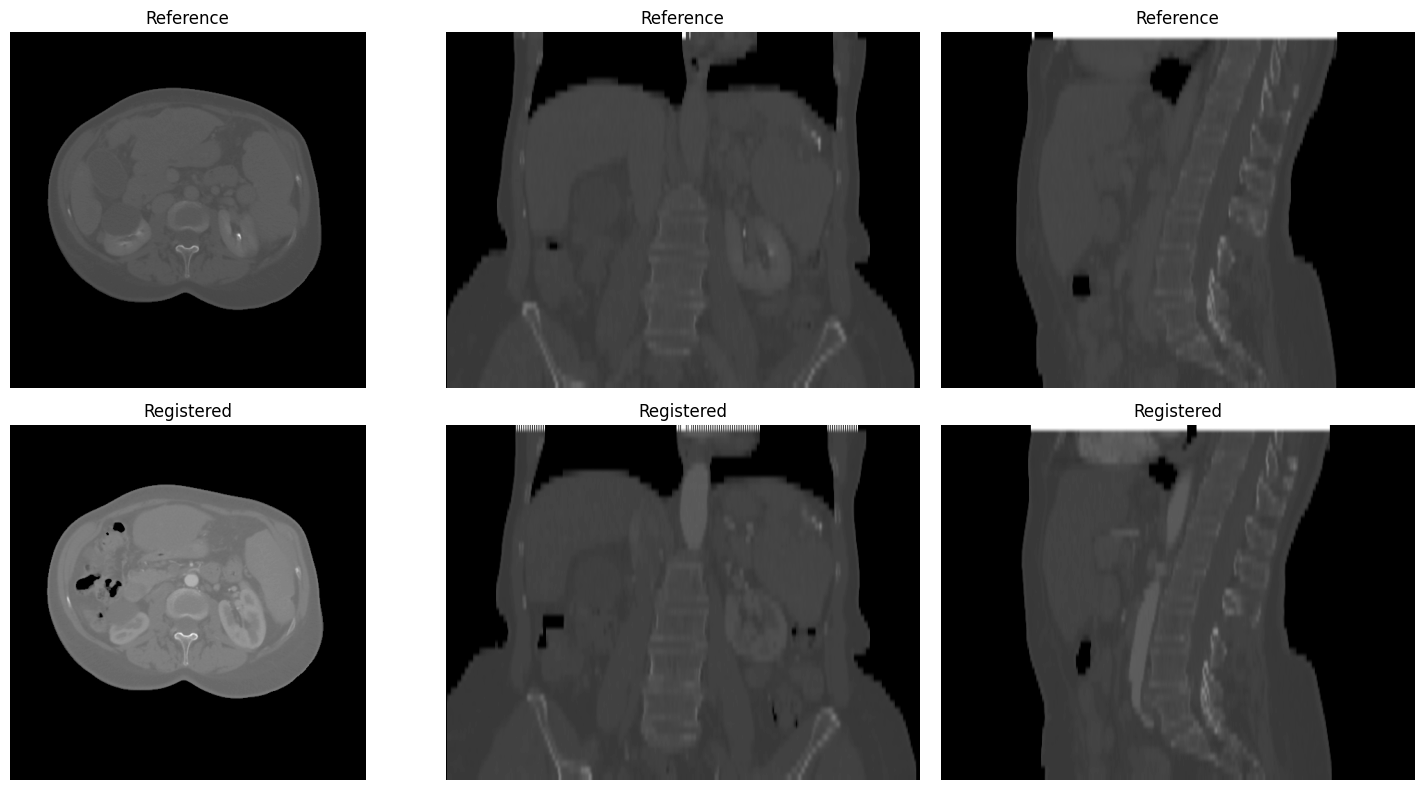

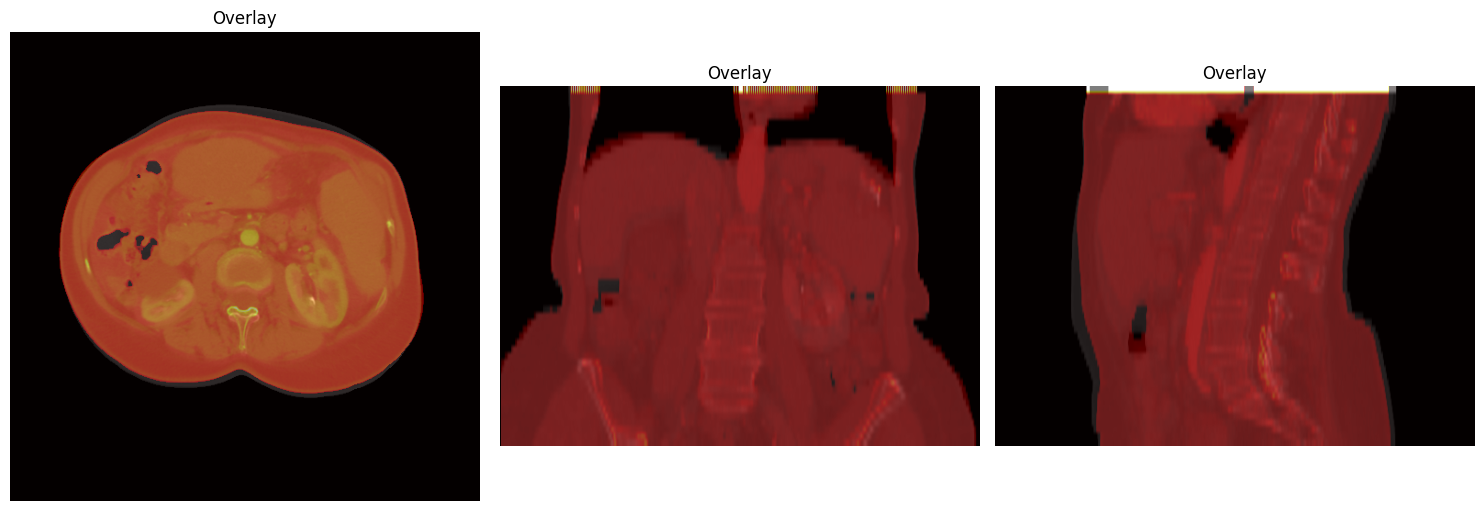

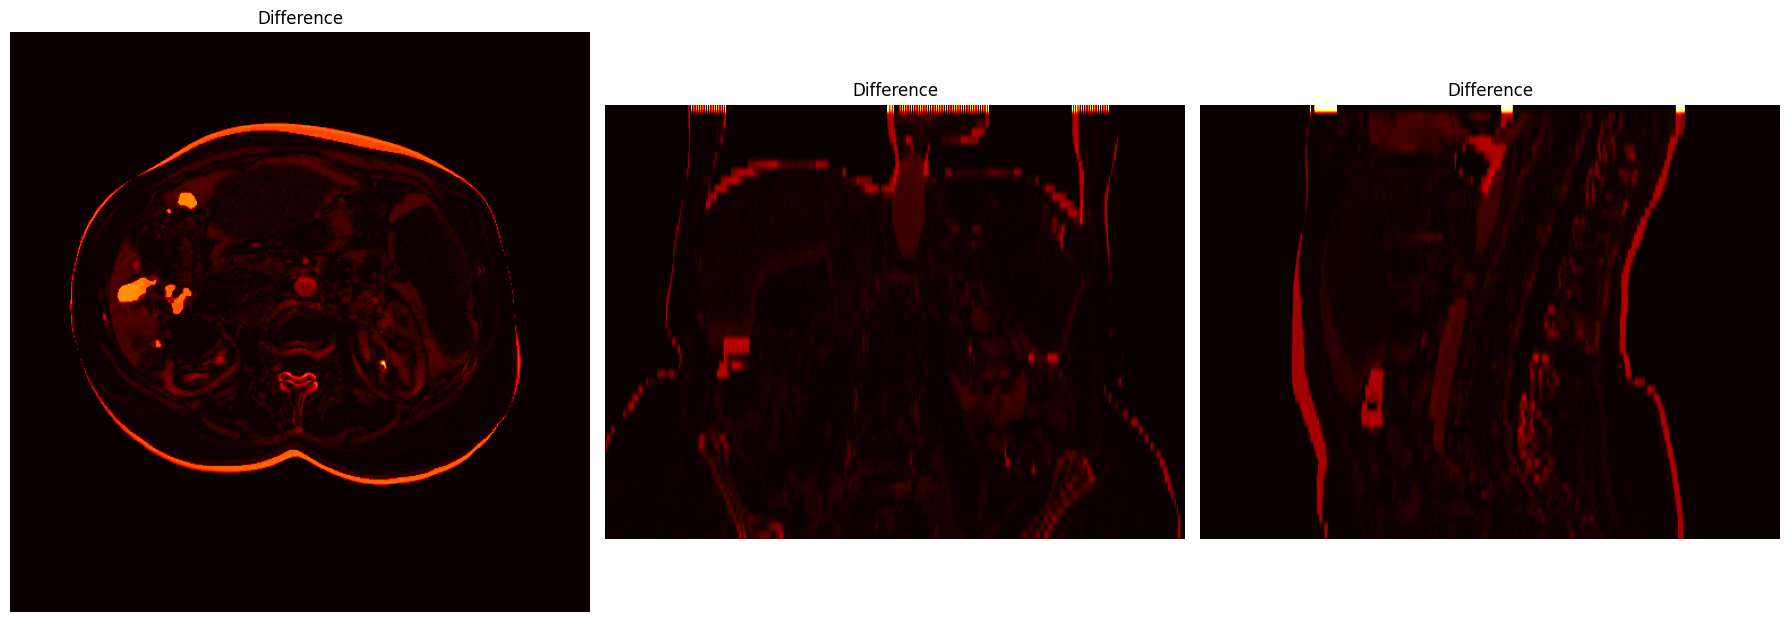

In [47]:
show_side_by_side(ct_volumeReference, ct_volumeInput)
show_overlay(ct_volumeReference, ct_volumeInput)
show_difference(ct_volumeReference, ct_volumeInput)

In [48]:
def plot_landmarks(ref_landmarks, inp_landmarks, transformed_landmarks=None):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot reference landmarks in blue
    ax.scatter(ref_landmarks[:, 0], ref_landmarks[:, 1], ref_landmarks[:, 2],
               c='blue', marker='o', label='Reference')

    # Plot input landmarks in red
    ax.scatter(inp_landmarks[:, 0], inp_landmarks[:, 1], inp_landmarks[:, 2],
               c='red', marker='^', label='Input')

    # Optionally plot transformed input landmarks in green
    if transformed_landmarks is not None:
        ax.scatter(transformed_landmarks[:, 0], transformed_landmarks[:, 1], transformed_landmarks[:, 2],
                   c='green', marker='x', label='Transformed Input')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title('3D Landmarks: Reference (blue), Input (red), Transformed (green)')
    plt.show()

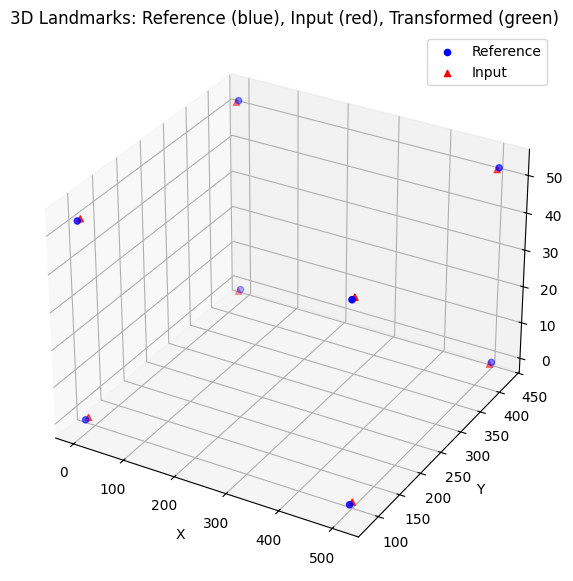

In [49]:
plot_landmarks(ref_landmarks, inp_landmarks)

# Experiments

## First transformation 

In [50]:
angle = 0
t1,t2,t3 = 0,0,0
initial_parameters = [
    t1,t2,t3,
    angle,
    1, 0, 0
]

In [51]:
def coregister_using_centroids(ref_landmarks, inp_landmarks, initial_parameters):
    result = coregister_landmarks(ref_landmarks, inp_landmarks, initial_parameters)
    t1, t2, t3, angle, v1, v2, v3 = result.x
    print(f'Best parameters:')
    print(f'  >> Translation: ({t1:0.02f}, {t2:0.02f}, {t3:0.02f}).')
    print(f'  >> Rotation: {angle:0.02f} rads around axis ({v1:0.02f}, {v2:0.02f}, {v3:0.02f}).')
    return result

In [52]:
print(ct_volumeInput.shape)

(54, 512, 512)


In [53]:
def get_voxel_coordinates(volume_shape):
    # Return an array of shape (num_voxels, 3) with all voxel coordinates
    X, Y, Z = volume_shape
    xv, yv, zv = np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij')
    coords = np.stack([xv.flatten(), yv.flatten(), zv.flatten()], axis=1)  # shape (N,3)
    return coords

In [54]:
def sample_volume(volume, coords):
    coords_T = coords.T  # shape (3,N)
    sampled_values = scipy.ndimage.map_coordinates(volume, coords_T, order=1, mode='nearest')
    return sampled_values

In [55]:
def transform_volume_coordinates(coords, parameters):
    transformed_coords = np.array([translation_then_axialrotation(tuple(coord), parameters) for coord in coords])
    return transformed_coords

`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 1.2100e+02, final cost 1.2100e+02, first-order optimality 5.55e-03.
Best parameters:
  >> Translation: (0.00, -0.50, 0.00).
  >> Rotation: 0.00 rads around axis (1.00, 0.00, 0.00).


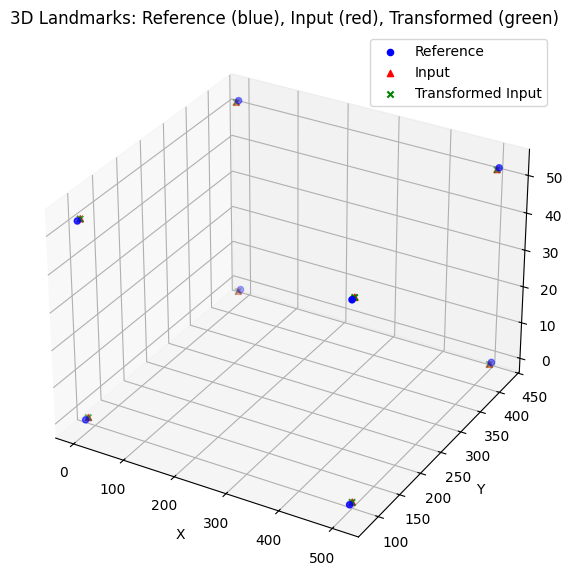

In [56]:
result = coregister_using_centroids(ref_landmarks, inp_landmarks, initial_parameters)
transformed_inp = transform_volume_coordinates(inp_landmarks, result.x)
plot_landmarks(ref_landmarks, inp_landmarks, transformed_inp)

In [ ]:
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(ct_volumeInput, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)

In [ ]:
metrics(ct_volumeReference, registered_volume)

MSE: 1053.8353623990658
MAE: 46.978035043787074
Normalized Cross Correlation: 0.9441540703742508
Normalized Mutual Information:  0.5171597545561668


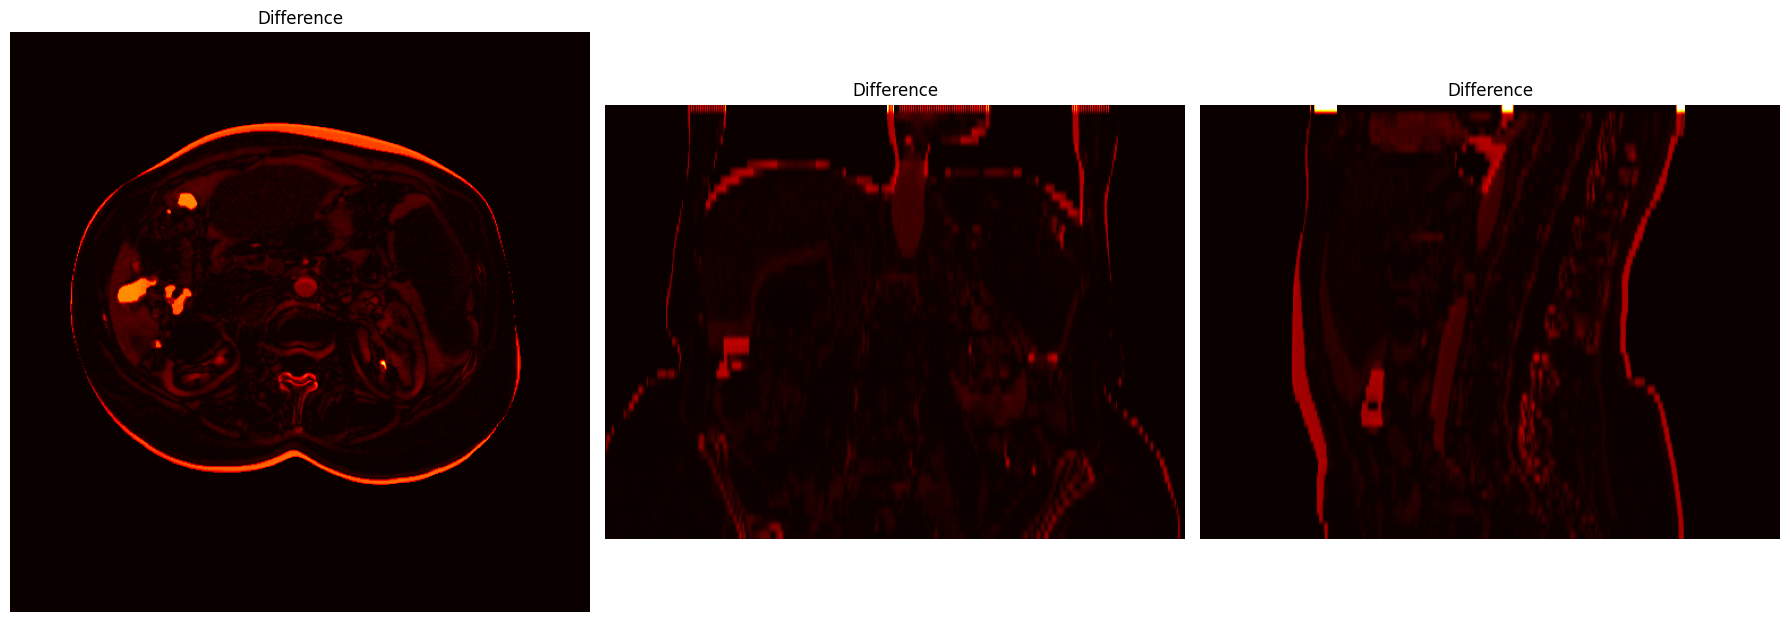

In [ ]:
show_difference(ct_volumeReference, registered_volume)

## Second Transformation

In [ ]:
coords = get_voxel_coordinates(registered_volume.shape)
transformed_coords = transform_volume_coordinates(coords, [0.00, -0.50, 0.00, 0.0, 1.00, 0.00, 0.00])
registered_volume = sample_volume(registered_volume, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)

In [ ]:
body_mask_input = segment_body(registered_volume)
bbox_input = extract_bbox(body_mask_input)
inp_landmarks = bbox_corners(bbox_input)
print("Reference Landmarks", ref_landmarks)
print("Input Landmarks",inp_landmarks)

Umbral de Otsu: -500
Reference Landmarks [[  1  80   0]
 [511  80   0]
 [  1 428   0]
 [511 428   0]
 [  1  80  53]
 [511  80  53]
 [  1 428  53]
 [511 428  53]]
Input Landmarks [[  2  89   0]
 [511  89   0]
 [  2 425   0]
 [511 425   0]
 [  2  89  53]
 [511  89  53]
 [  2 425  53]
 [511 425  53]]


In [ ]:
print(ref_landmarks - inp_landmarks)

[[ 0 -7  0]
 [ 0 -7  0]
 [ 0  5  0]
 [ 0  5  0]
 [ 0 -7  0]
 [ 0 -7  0]
 [ 0  5  0]
 [ 0  5  0]]


In [ ]:
t1, t2, t3 = 0,-1,0
angle = 0.2
initial_parameters = [
    t1,t2,t3,
    angle,
    1, 1, 0
]

The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 2.7514e+04, final cost 1.5506e+02, first-order optimality 4.83e+01.
Best parameters:
  >> Translation: (-0.15, -2.30, -1.03).
  >> Rotation: -0.00 rads around axis (0.95, 1.05, 0.21).


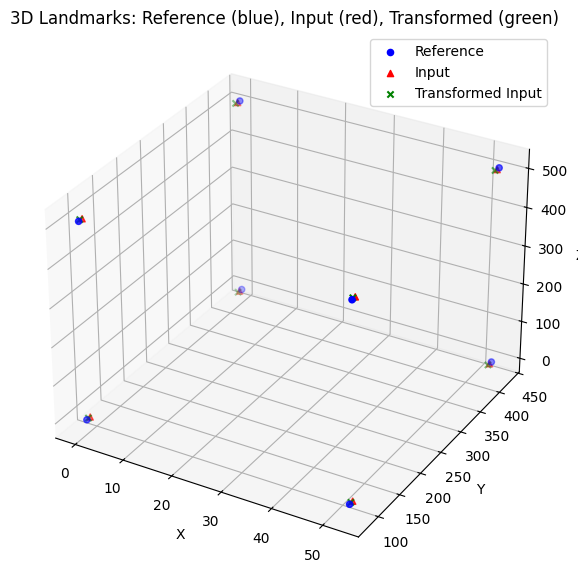

In [ ]:
result = coregister_using_centroids(ref_landmarks, inp_landmarks, initial_parameters)
transformed_inp = transform_volume_coordinates(inp_landmarks, result.x)
plot_landmarks(ref_landmarks, inp_landmarks, transformed_inp)

In [ ]:
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(registered_volume, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)
metrics(ct_volumeReference, registered_volume)

MSE: 937.1828491776077
MAE: 41.20154303091544
Normalized Cross Correlation: 0.9524957233597752
Normalized Mutual Information:  0.5475019680410205


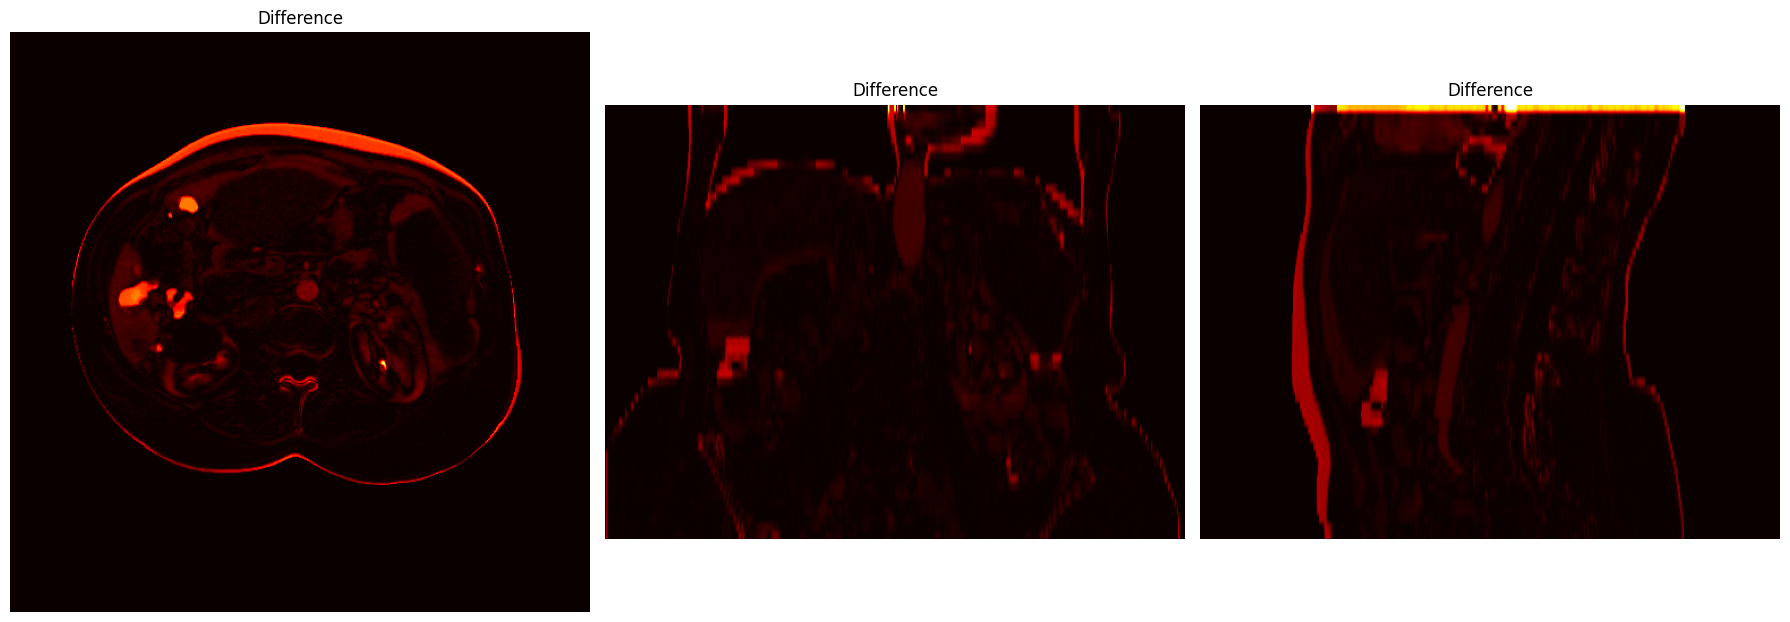

In [ ]:
show_difference(ct_volumeReference, registered_volume)

In [ ]:
show_side_by_side(ct_volumeReference, ct_volumeInput)
show_overlay(ct_volumeReference, ct_volumeInput)

In [ ]:
break;

## Third transformation

In [ ]:
coords = get_voxel_coordinates(registered_volume.shape)
transformed_coords = transform_volume_coordinates(coords,[-0.15, -2.30, -1.03, 0, 0.95, 1.05, 0.21])
registered_volume = sample_volume(registered_volume, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)

In [ ]:
body_mask_input = segment_body(registered_volume)
bbox_input = extract_bbox(body_mask_input)
inp_landmarks = bbox_corners(bbox_input)
print("Reference Landmarks", ref_landmarks)
print("Input Landmarks",inp_landmarks)

Umbral de Otsu: -499
Reference Landmarks [[  0  80   1]
 [  0  80 511]
 [  0 428   1]
 [  0 428 511]
 [ 53  80   1]
 [ 53  80 511]
 [ 53 428   1]
 [ 53 428 511]]
Input Landmarks [[  0  90   2]
 [  0  90 511]
 [  0 426   2]
 [  0 426 511]
 [ 53  90   2]
 [ 53  90 511]
 [ 53 426   2]
 [ 53 426 511]]


In [ ]:
print(ref_landmarks - inp_landmarks)

[[  0 -10  -1]
 [  0 -10   0]
 [  0   2  -1]
 [  0   2   0]
 [  0 -10  -1]
 [  0 -10   0]
 [  0   2  -1]
 [  0   2   0]]


In [ ]:
t1, t2, t3 = -1,0,0
angle = 0
initial_parameters = [
    t1,t2,t3,
    angle,
    1, 0,0
]

`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 1.4500e+02, final cost 1.4500e+02, first-order optimality 6.08e-03.
Best parameters:
  >> Translation: (0.00, -4.00, -0.50).
  >> Rotation: 0.00 rads around axis (1.00, 0.00, 0.00).


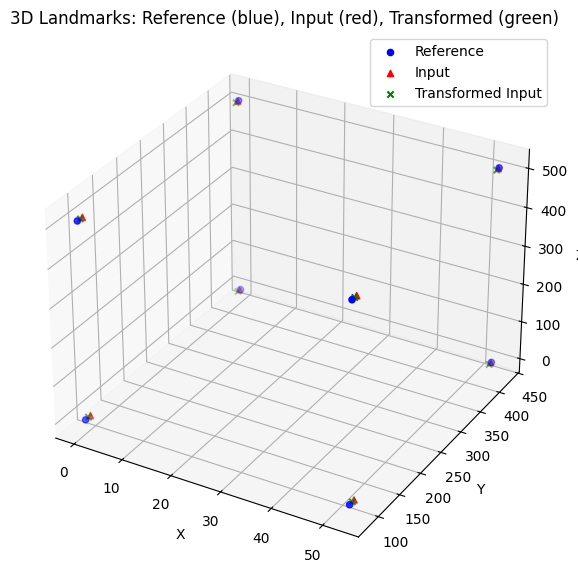

In [ ]:
result = coregister_using_centroids(ref_landmarks, inp_landmarks, initial_parameters)
transformed_inp = transform_volume_coordinates(inp_landmarks, result.x)
plot_landmarks(ref_landmarks, inp_landmarks, transformed_inp)

In [ ]:
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(registered_volume, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)
metrics(ct_volumeReference, registered_volume)

MSE: 1248.8675552650734
MAE: 66.45665048669886
Normalized Cross Correlation: 0.9119988605496184
Normalized Mutual Information:  0.44387534499310227


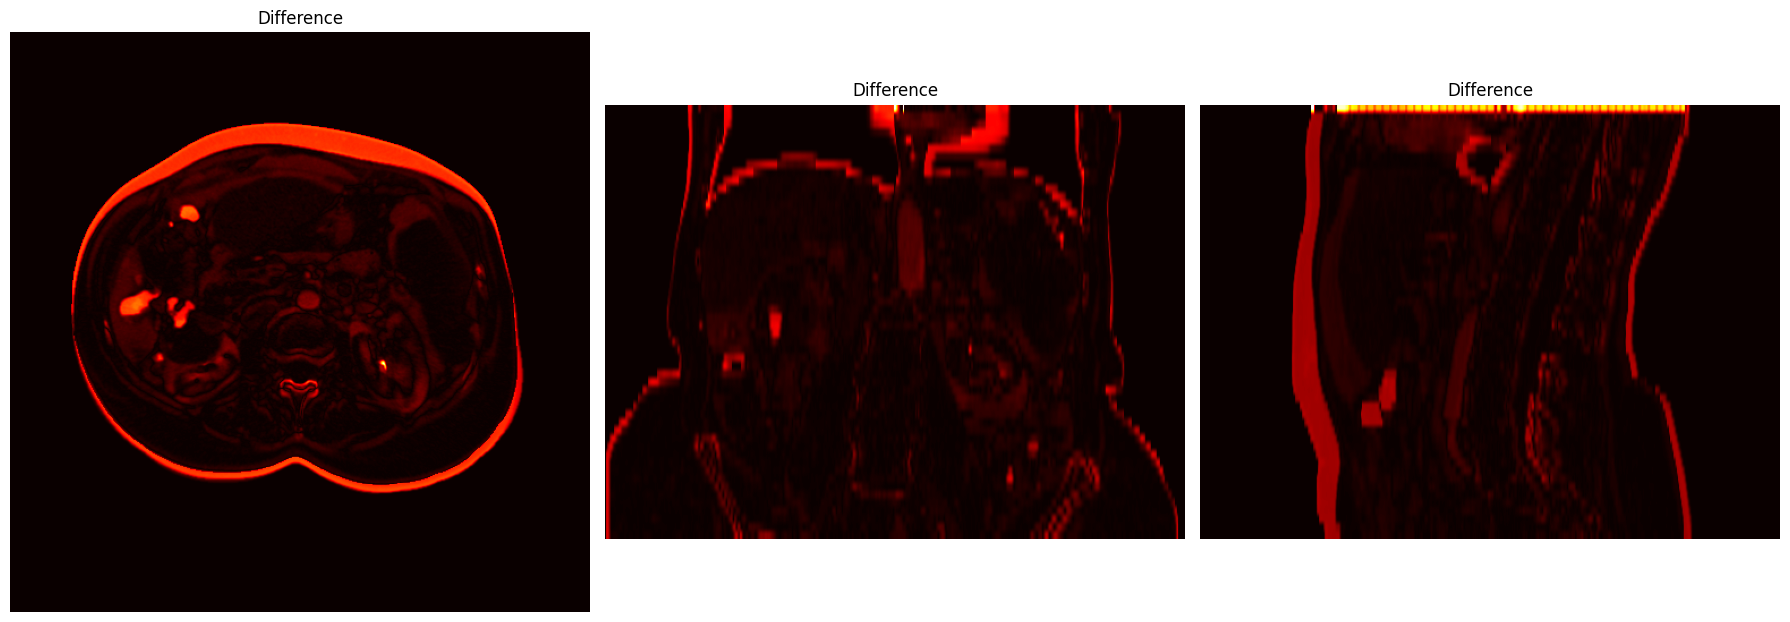

In [ ]:
show_difference(ct_volumeReference, registered_volume)

## Random Initial Parameters

In [ ]:
bbox_reference = extract_bbox(body_mask_reference)
ref_landmarks = bbox_corners(bbox_reference)
bbox_input = extract_bbox(body_mask_input)
inp_landmarks = bbox_corners(bbox_input)

In [ ]:
def random_rigid_parameters(translation_scale=5, angle_scale=np.pi/6):
    t = np.random.uniform(-translation_scale, translation_scale, 3)
    axis = np.random.normal(size=3)
    axis /= np.linalg.norm(axis)
    angle = np.random.uniform(0, angle_scale)
    return np.concatenate([t, [angle], axis])

In [ ]:
def coregister_landmarks_multi(ref_landmarks, inp_landmarks, n_attempts=20):
    best_score = np.inf
    best_result = None

    for i in range(n_attempts):
        init_params = random_rigid_parameters()
        result = coregister_using_centroids(ref_landmarks, inp_landmarks, init_params)
        transformed_inp = transform_volume_coordinates(inp_landmarks, result.x)
        score = np.mean(vector_of_residuals(ref_landmarks,transformed_inp))

        print(f"Attempt {i+1}: Score = {score:.5f}")
        if score < best_score:
            best_score = score
            best_result = result

    return best_result, best_score

In [ ]:
result,bestscore = coregister_landmarks_multi(ref_landmarks, inp_landmarks, 10)

`ftol` termination condition is satisfied.
Function evaluations 81, initial cost 1.1605e+05, final cost 1.4500e+02, first-order optimality 3.95e-01.
Best parameters:
  >> Translation: (0.00, -4.01, -0.49).
  >> Rotation: -0.00 rads around axis (4.23, 3.08, 2.22).
Attempt 1: Score = 6.02080
The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 6.2771e+04, final cost 1.9905e+02, first-order optimality 3.77e+01.
Best parameters:
  >> Translation: (-2.26, -7.08, -2.05).
  >> Rotation: 0.00 rads around axis (-0.32, 0.77, -0.56).
Attempt 2: Score = 6.55982
`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 1.6073e+02, final cost 1.4500e+02, first-order optimality 6.62e-02.
Best parameters:
  >> Translation: (0.00, -4.00, -0.50).
  >> Rotation: 0.00 rads around axis (0.47, -0.41, 0.78).
Attempt 3: Score = 6.02080
The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 1.3265e+05, fina

6.020797289415876


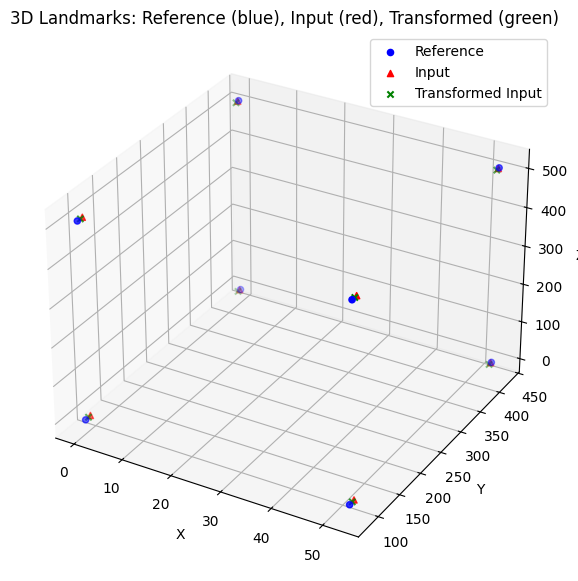

In [ ]:
print(bestscore)
transformed_inp = transform_volume_coordinates(inp_landmarks, result.x)
plot_landmarks(ref_landmarks, inp_landmarks, transformed_inp)

In [ ]:
print(result.x)

[ 1.04497397e-05 -4.00000126e+00 -5.00004468e-01  6.27746597e-08
  4.74271490e-01 -4.10005265e-01  7.79077812e-01]


In [ ]:
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(ct_volumeInput, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)
metrics(ct_volumeReference, registered_volume)

MSE: 957.1111036230017
MAE: 42.080630973533346
Normalized Cross Correlation: 0.9488581722138174
Normalized Mutual Information:  0.5430396239773172


The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 3.2800e+03, final cost 1.4828e+02, first-order optimality 1.19e+01.
Best parameters:
  >> Translation: (0.11, -0.77, -0.47).
  >> Rotation: -0.00 rads around axis (0.58, -0.89, -0.15).
Attempt 1: Score = 6.04204
The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 1.1198e+05, final cost 1.4741e+02, first-order optimality 5.60e+00.
Best parameters:
  >> Translation: (-0.76, -0.60, -0.22).
  >> Rotation: 0.00 rads around axis (-0.30, 0.85, -0.44).
Attempt 2: Score = 6.04858
The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 7.8433e+02, final cost 1.4878e+02, first-order optimality 7.50e+00.
Best parameters:
  >> Translation: (0.27, -0.93, -0.12).
  >> Rotation: 0.00 rads around axis (0.33, 0.05, 0.95).
Attempt 3: Score = 6.02710
`ftol` termination condition is satisfied.
Function evaluations 61, initial cost 6

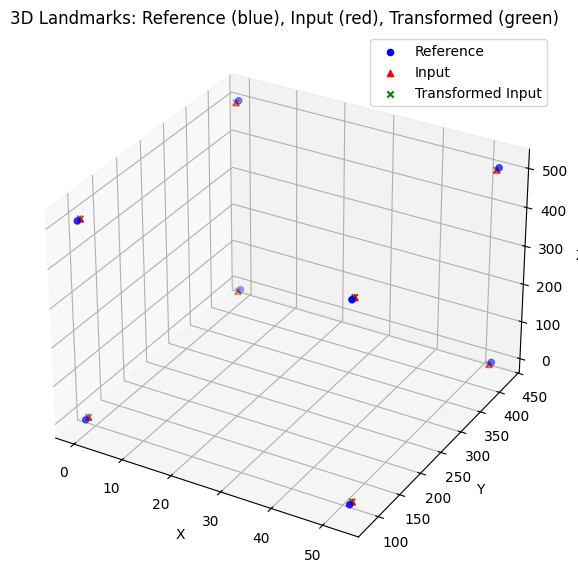

In [ ]:
result,bestscore = coregister_landmarks_multi(ref_landmarks, transformed_inp, 10)
print(bestscore)
transformed_inp2 = transform_volume_coordinates(transformed_inp, result.x)
plot_landmarks(ref_landmarks, transformed_inp, transformed_inp2)

In [ ]:
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(ct_volumeInput, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)
metrics(ct_volumeReference, registered_volume)

MSE: 1077.6402182402435
MAE: 47.69624766597041
Normalized Cross Correlation: 0.9416708116306995
Normalized Mutual Information:  0.5120447290477844


The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 1.8270e+04, final cost 1.4642e+02, first-order optimality 6.32e+00.
Best parameters:
  >> Translation: (0.35, -0.64, 0.54).
  >> Rotation: 0.00 rads around axis (-0.73, -0.35, 0.72).
Attempt 1: Score = 6.03542
The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 5.0643e+04, final cost 1.4871e+02, first-order optimality 1.40e+01.
Best parameters:
  >> Translation: (-0.03, -0.98, -0.00).
  >> Rotation: -0.00 rads around axis (0.35, 0.94, 0.03).
Attempt 2: Score = 6.02600
`ftol` termination condition is satisfied.
Function evaluations 59, initial cost 6.5229e+04, final cost 1.4501e+02, first-order optimality 5.95e-01.
Best parameters:
  >> Translation: (-0.03, 0.02, 0.03).
  >> Rotation: -0.00 rads around axis (0.73, 0.30, 0.63).
Attempt 3: Score = 6.02089
The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 1.42

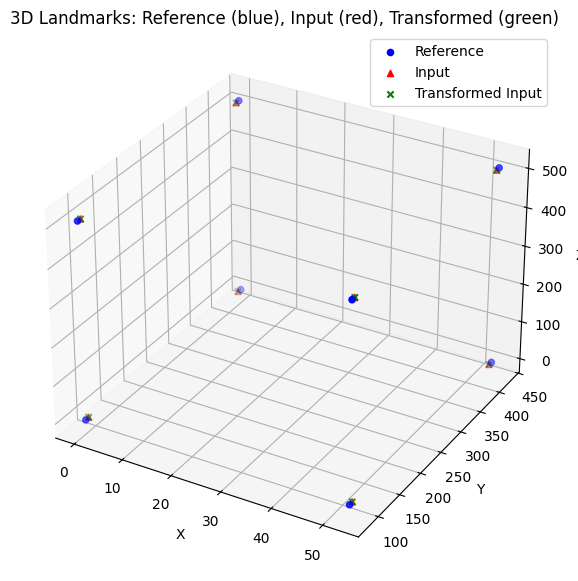

In [ ]:
result,bestscore = coregister_landmarks_multi(ref_landmarks, transformed_inp2, 10)
print(bestscore)
transformed_inp3 = transform_volume_coordinates(transformed_inp2, result.x)
plot_landmarks(ref_landmarks, transformed_inp3, transformed_inp2)

In [ ]:
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(ct_volumeInput, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)
metrics(ct_volumeReference, registered_volume)

MSE: 1074.389773192229
MAE: 47.58874116120515
Normalized Cross Correlation: 0.9423068670067498
Normalized Mutual Information:  0.512547885421826


## Medium size

In [ ]:
new_shape = (27, 256, 256)
ct_volumeReference_small = resize(ct_volumeReference, new_shape, anti_aliasing=True, preserve_range=True)
ct_volumeInput_small= resize(ct_volumeInput, new_shape, anti_aliasing=True, preserve_range=True)

In [ ]:
print(mean_squared_error(ct_volumeReference_small, ct_volumeInput_small))
print(mean_absolute_error(ct_volumeReference_small, ct_volumeInput_small))
print(normalized_cross_correlation(ct_volumeReference_small, ct_volumeInput_small))
print(normalized_mutual_information(ct_volumeReference_small, ct_volumeInput_small))

18772.03863237523
42.29270335920933
0.9612700172132449
0.49355095163866647


In [ ]:
new_shape = (27, 256, 256)
body_mask_reference_small = resize(body_mask_reference, new_shape, preserve_range=True)
body_mask_input_small= resize(body_mask_input, new_shape, preserve_range=True)
bbox_reference_small = extract_bbox(body_mask_reference_small)
ref_landmarks_small = bbox_corners(bbox_reference_small)
body_mask_input_small = extract_bbox(body_mask_input_small)
inp_landmarks_small = bbox_corners(body_mask_input_small)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9811e+04                                    2.23e+05    
       1              2         6.1702e+01      5.97e+04       1.23e+00       5.47e+03    
       2              3         3.4207e+01      2.75e+01       2.47e+00       1.48e+03    
       3              9         3.1609e+01      2.60e+00       2.41e-03       6.75e+02    
       4             11         3.1038e+01      5.71e-01       1.21e-03       2.73e+02    
       5             12         3.0951e+01      8.67e-02       1.21e-03       1.29e+02    
       6             14         3.0927e+01      2.41e-02       3.01e-04       2.92e+01    
       7             16         3.0926e+01      1.49e-03       7.54e-05       9.06e+00    
       8             17         3.0925e+01      6.99e-04       7.54e-05       9.07e+00    
       9             18         3.0924e+01      1.38e-03       1.51e-04       9.05e+00    

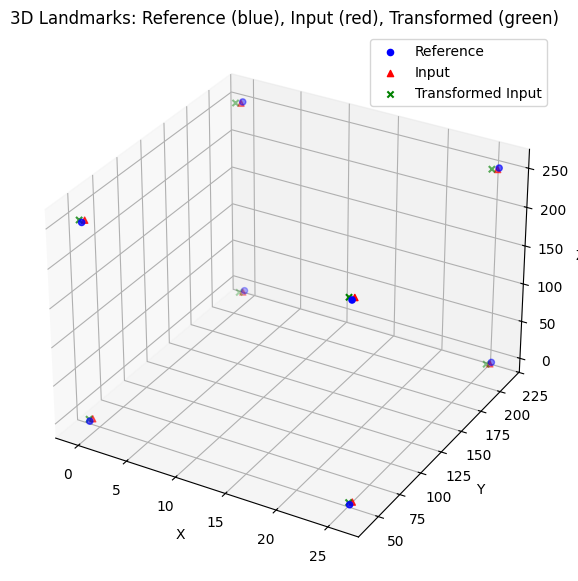

In [ ]:
result = coregister_using_centroids(ref_landmarks_small, inp_landmarks_small, initial_parameters)
transformed_inp = transform_volume_coordinates(inp_landmarks_small, result.x)
plot_landmarks(ref_landmarks_small, inp_landmarks_small, transformed_inp)

In [ ]:
coords = get_voxel_coordinates(ct_volumeInput_small.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(ct_volumeInput_small, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput_small.shape)

In [ ]:
print(mean_squared_error(ct_volumeReference_small, registered_volume))
print(mean_absolute_error(ct_volumeReference_small, registered_volume))
print(normalized_cross_correlation(ct_volumeReference_small, registered_volume))
print(normalized_mutual_information(ct_volumeReference_small, registered_volume))

14835.719699824594
38.32565311867126
0.9694975401077719
0.5153119137225866


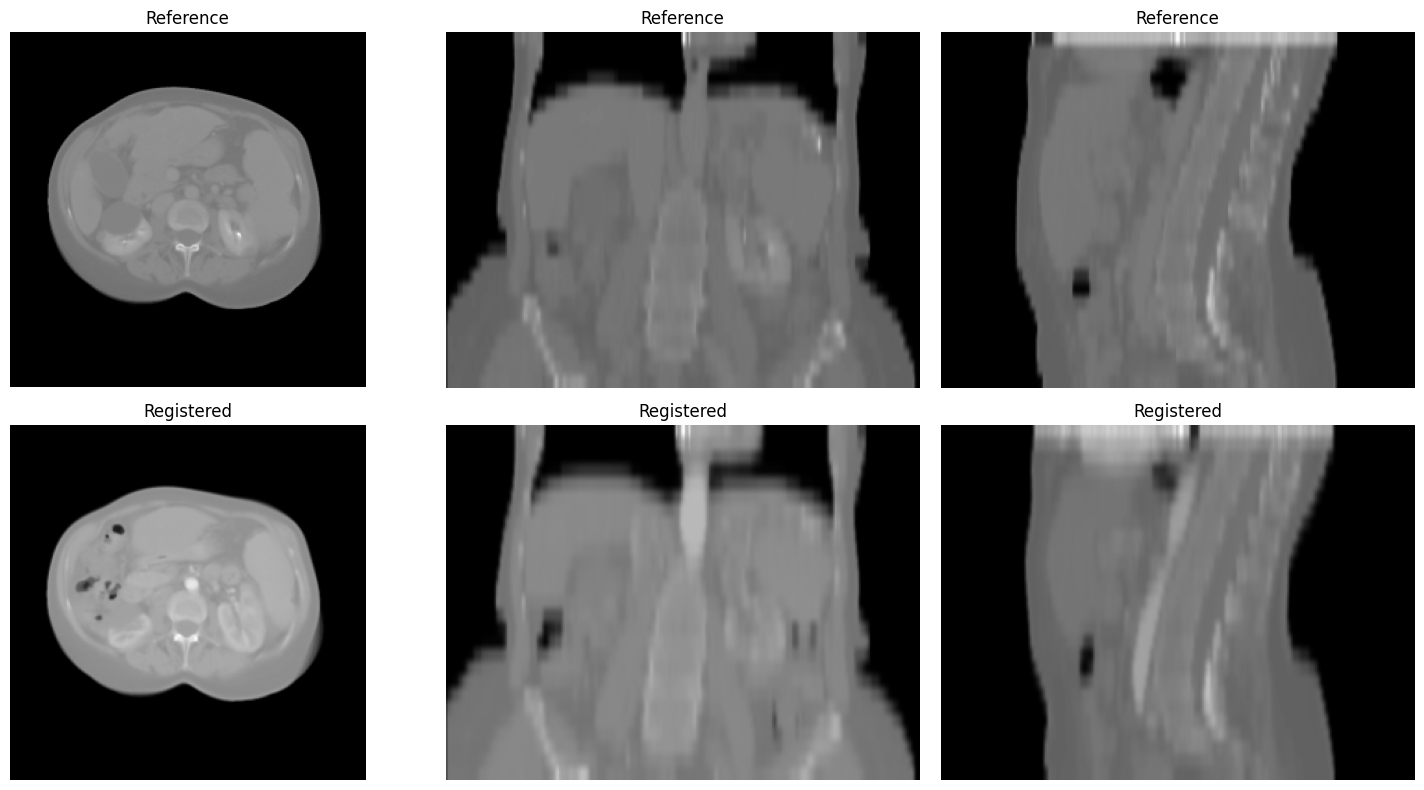

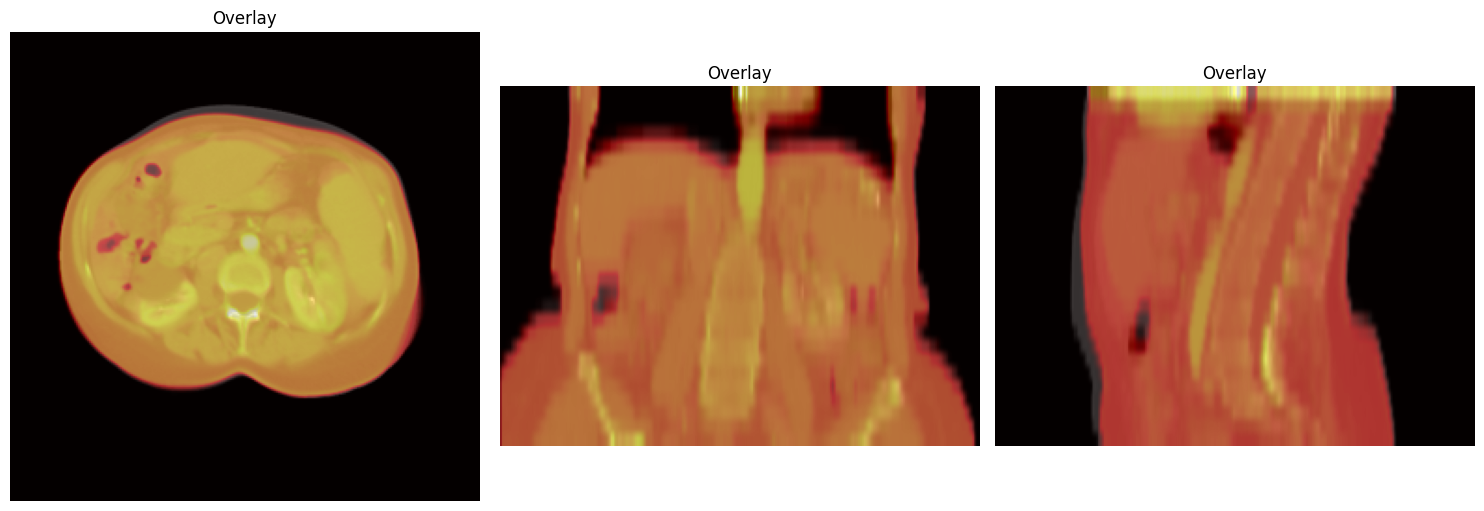

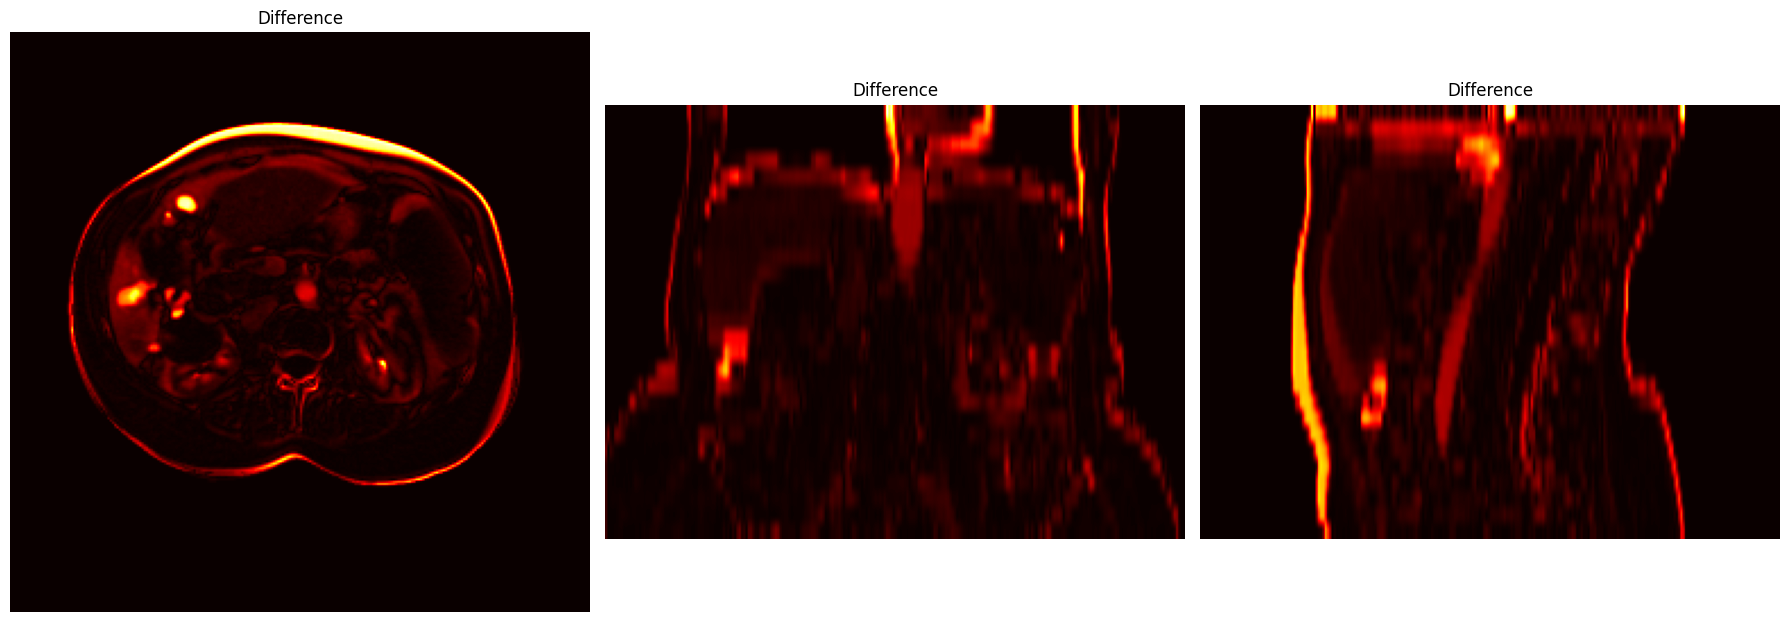

In [ ]:
show_side_by_side(ct_volumeReference_small, registered_volume)
show_overlay(ct_volumeReference_small, registered_volume)
show_difference(ct_volumeReference_small, registered_volume)

After Resize

In [ ]:
new_shape = (54, 512, 512)
ct_volumeReference_small = resize(ct_volumeReference_small, new_shape, anti_aliasing=True, preserve_range=True)
registered_volume= resize(registered_volume, new_shape, anti_aliasing=True, preserve_range=True)

In [ ]:
print(mean_squared_error(ct_volumeReference_small, registered_volume))
print(mean_absolute_error(ct_volumeReference_small, registered_volume))
print(normalized_cross_correlation(ct_volumeReference_small, registered_volume))
print(normalized_mutual_information(ct_volumeReference_small, registered_volume))

12058.477383552037
35.392849003177204
0.9749217108622578
0.5239624449154131


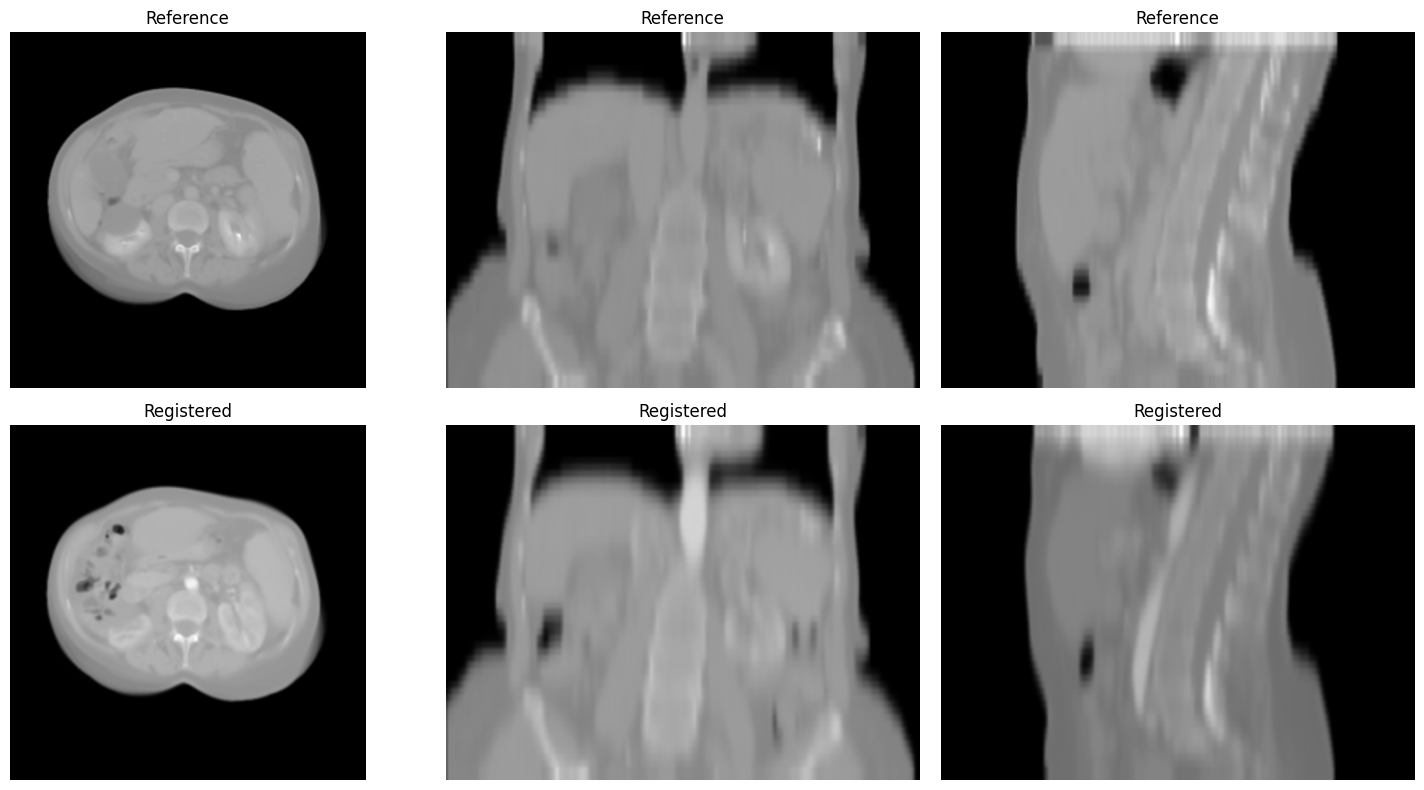

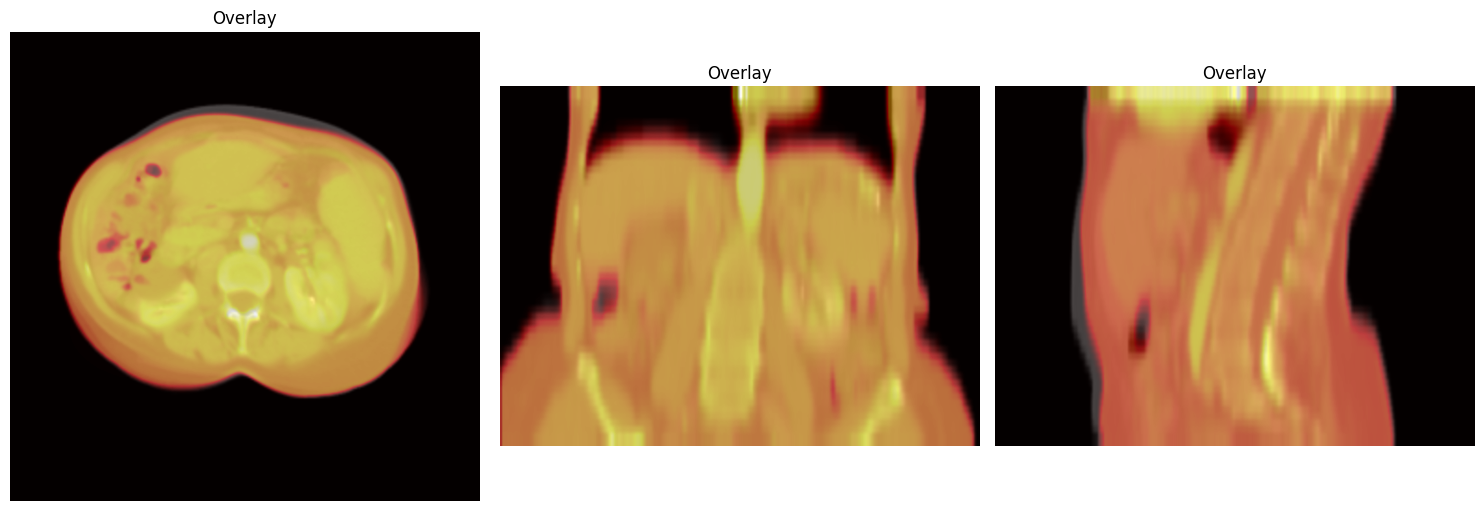

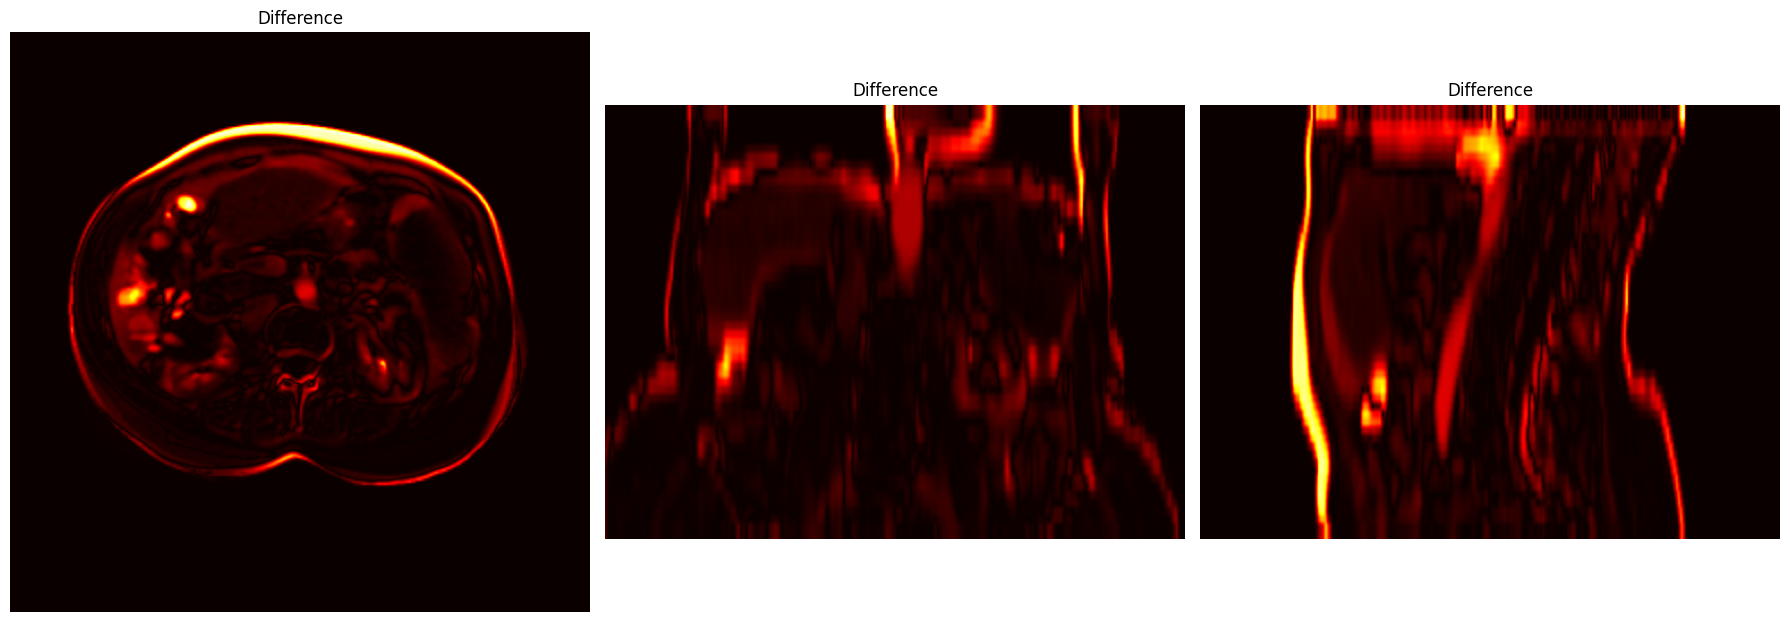

In [ ]:
show_side_by_side(ct_volumeReference_small, registered_volume)
show_overlay(ct_volumeReference_small, registered_volume)
show_difference(ct_volumeReference_small, registered_volume)

## Screw Displacement

In [ ]:
def screw_displacement(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` the screw displacement defined by `parameters`. """
    x, y, z = point
    v1, v2, v3, angle_in_rads, displacement = parameters
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm
    x, y, z = translation(point=(x, y, z), translation_vector=(displacement*v1, displacement*v2, displacement*v3))
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    return x, y, z

In [ ]:
def coregister_landmarks(ref_landmarks: np.ndarray, inp_landmarks: np.ndarray, initial_parameters):
    """ Coregister two sets of landmarks using a rigid transformation. """
    # Find better initial parameters
    centroid_ref = np.mean(ref_landmarks, axis=0)
    centroid_inp = np.mean(inp_landmarks, axis=0)

    initial_parameters[0] = centroid_ref[0] - centroid_inp[0]
    initial_parameters[1] = centroid_ref[1] - centroid_inp[1]
    initial_parameters[2] = centroid_ref[2] - centroid_inp[2]

    def function_to_minimize(parameters):
        """ Transform input landmarks, then compare with reference landmarks."""
        inp_landmarks_transf = np.asarray([screw_displacement(point, parameters) for point in inp_landmarks])
        return vector_of_residuals(ref_landmarks, inp_landmarks_transf)

    # Apply least squares optimization
    result = least_squares(
        function_to_minimize,
        x0=initial_parameters,
        verbose=2)
    return result

In [ ]:
def coregister_using_centroids(ref_landmarks, inp_landmarks, initial_parameters):
    result = coregister_landmarks(ref_landmarks, inp_landmarks, initial_parameters)
    v1,v2,v3, angle, displacement = result.x
    print(f'Best parameters:')
    print(f'  >> Displacement: ({displacement}).')
    print(f'  >> Rotation: {angle:0.02f} rads around axis ({v1:0.02f}, {v2:0.02f}, {v3:0.02f}).')
    return result


In [ ]:
def transform_volume_coordinates(coords, parameters):
    transformed_coords = np.array([screw_displacement(tuple(coord), parameters) for coord in coords])
    return transformed_coords

In [ ]:
angle = 0
displacement = 0
initial_parameters = [
    1, 0, 0,
    angle, 
    displacement
]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1000e+02                                    3.22e+01    
       1              5         2.0929e+02      7.12e-01       6.30e-02       1.55e+03    
       2              9         2.0821e+02      1.08e+00       9.84e-04       6.42e+02    
       3             10         2.0802e+02      1.88e-01       9.84e-04       2.64e+02    
       4             12         2.0798e+02      3.79e-02       2.46e-04       3.87e+01    
       5             14         2.0798e+02      2.04e-03       6.15e-05       3.17e+01    
       6             15         2.0798e+02      1.93e-03       6.15e-05       3.17e+01    
       7             16         2.0798e+02      3.83e-03       1.23e-04       3.17e+01    
       8             17         2.0797e+02      5.72e-03       2.46e-04       5.75e+01    
       9             19         2.0797e+02      2.70e-03       6.15e-05       3.17e+01    

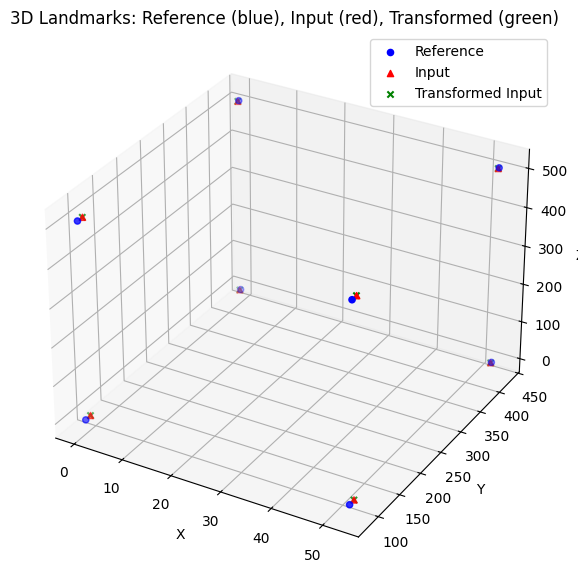

In [ ]:
result = coregister_using_centroids(ref_landmarks, inp_landmarks, initial_parameters)
transformed_inp = transform_volume_coordinates(inp_landmarks, result.x)
plot_landmarks(ref_landmarks, inp_landmarks, transformed_inp)

In [ ]:
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, result.x)
registered_volume = sample_volume(ct_volumeInput, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)

In [ ]:
print(mean_squared_error(ct_volumeReference, registered_volume))
print(mean_absolute_error(ct_volumeReference, registered_volume))
print(normalized_cross_correlation(ct_volumeReference, registered_volume))
print(normalized_mutual_information(ct_volumeReference, registered_volume))

1064.2880535125732
47.43566717924895
0.9428171066157313
0.5143105879911363


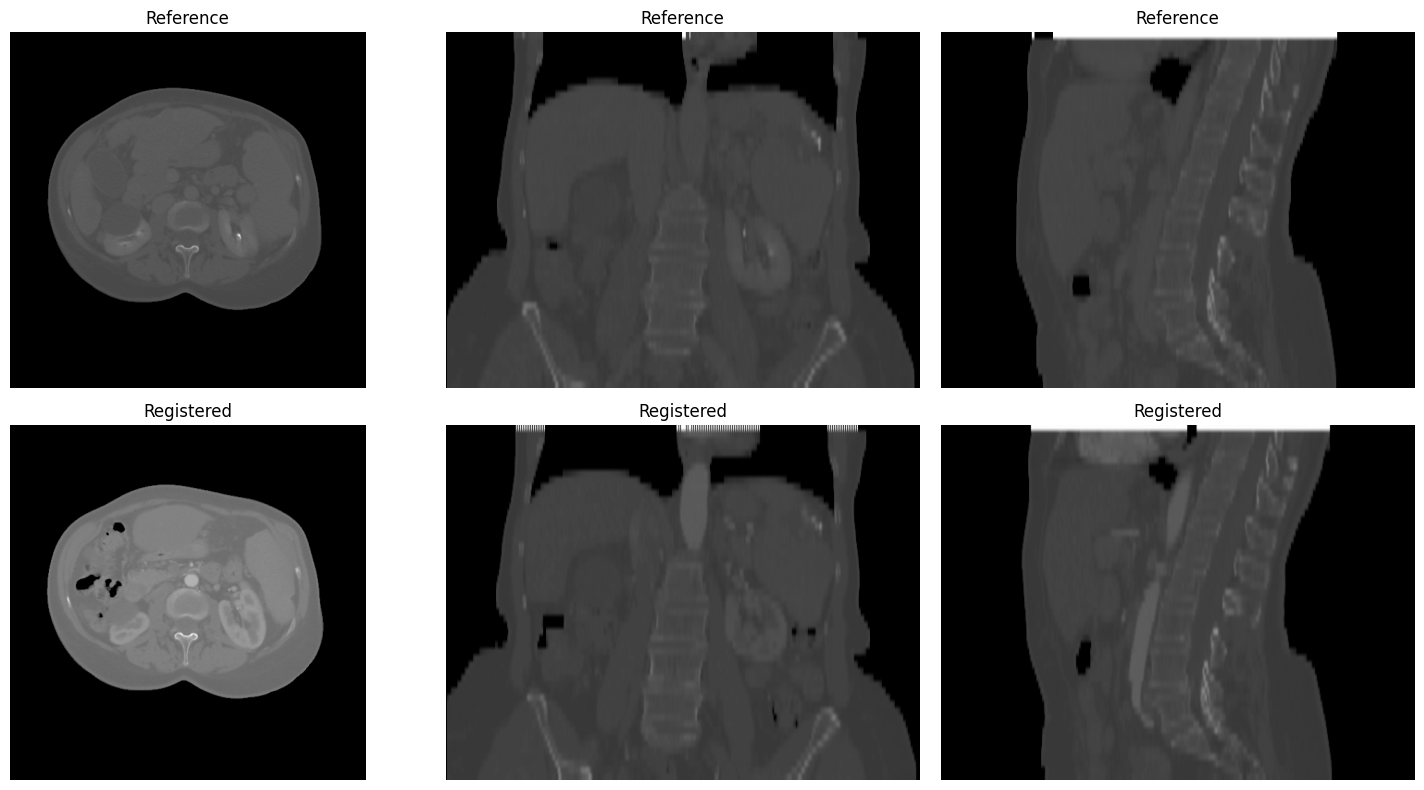

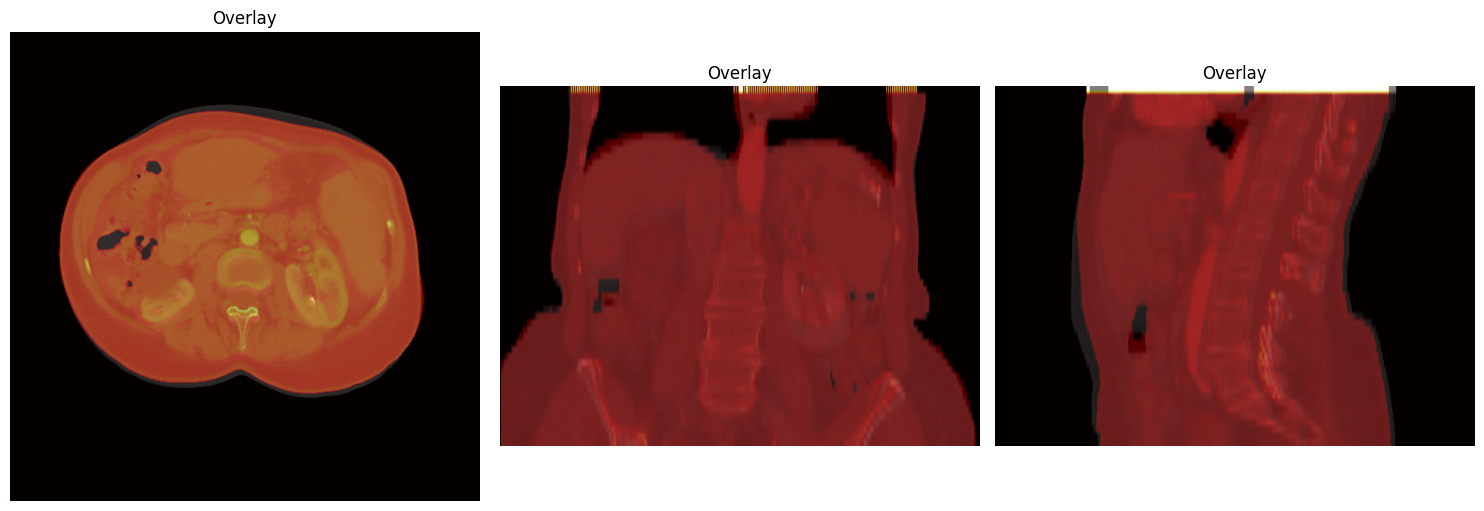

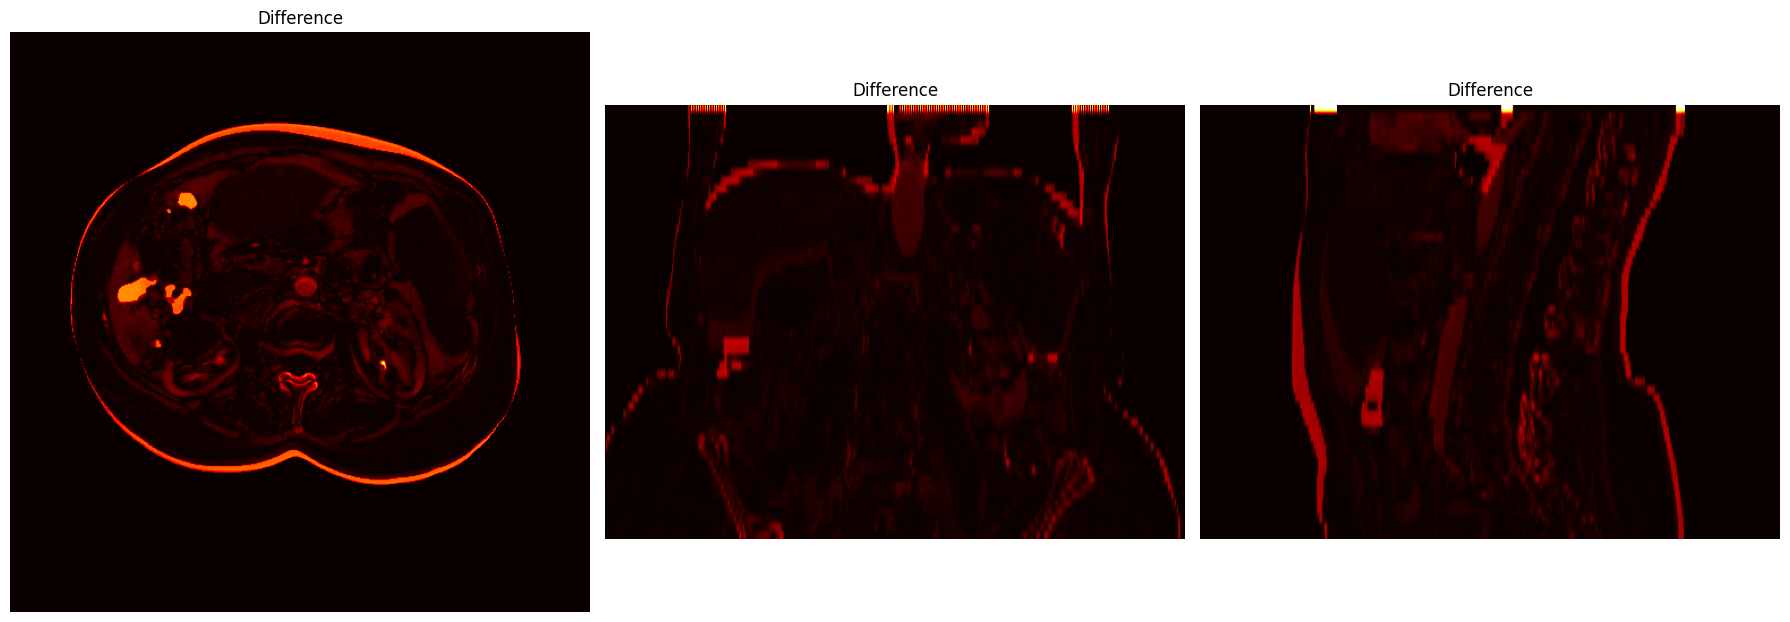

In [ ]:
show_side_by_side(ct_volumeReference, registered_volume)
show_overlay(ct_volumeReference, registered_volume)
show_difference(ct_volumeReference, registered_volume)

# Transform mask

In [ ]:
bbox_reference = extract_bbox(body_mask_reference)
ref_landmarks = bbox_corners(bbox_reference)
bbox_input = extract_bbox(body_mask_input)
inp_landmarks = bbox_corners(bbox_input)

In [ ]:
transformation1 = [0.00, -0.50, 0.00, 0.0, 1.00, 0.00, 0.00]
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(coords, transformation1)
registered_volume = sample_volume(ct_volumeInput, transformed_coords)
registered_volume = registered_volume.reshape(ct_volumeInput.shape)
metrics(ct_volumeReference, registered_volume)

In [ ]:
coords = get_voxel_coordinates(liver_volume.shape)
transformed_coords = transform_volume_coordinates(coords, transformation1)
registered_volume = sample_volume(liver_volume, transformed_coords)
registered_volume = registered_volume.reshape(liver_volume.shape)
metrics(ct_volumeReference, registered_volume)

In [ ]:
transformation2 = [-0.15, -2.30, -1.03, 0, 0.95, 1.05, 0.21]
coords = get_voxel_coordinates(ct_volumeInput.shape)
transformed_coords = transform_volume_coordinates(transformed_coords, transformation2)

In [ ]:
registered_volume = sample_volume(registered_volume, transformed_coords)
registered_volume = registered_volume.reshape(registered_volume.shape)
metrics(ct_volumeReference, registered_volume)

MSE: 990.1246070861816
MAE: 42.725754773175275
Normalized Cross Correlation: 0.9483124808262687
Normalized Mutual Information:  0.5393779192039231


In [ ]:
transformed_coords = transform_volume_coordinates(transformed_coords, transformation2)
registered_mask = sample_volume(liver_volume, transformed_coords)
registered_mask = registered_mask.reshape(liver_volume.shape)

In [ ]:
coords = get_voxel_coordinates(liver_volume.shape)
transformed_coords = transform_volume_coordinates(coords, transformation1)
transformed_coords = transform_volume_coordinates(transformed_coords, transformation2)
registered_mask = sample_volume(liver_volume, transformed_coords)
registered_mask = registered_mask.reshape(liver_volume.shape)

KeyboardInterrupt: 

In [ ]:
def apply_cmap(img: np.ndarray, cmap_name: str = 'bone') -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    cmap_function = matplotlib.colormaps[cmap_name]
    return cmap_function(img)
def visualize_alpha_fusion(img: np.ndarray, mask: np.ndarray, alpha: float = 0.25, aspect: int = 1):
    """ Visualize both image and mask in the same plot. """
    img_cmapped = apply_cmap(img, cmap_name='bone')
    mask_bone_cmapped = apply_cmap(mask, cmap_name='tab10')

    mask_condition = (mask == 1)
    
    final_img = img_cmapped.copy()
    final_img[mask_condition] = img_cmapped[mask_condition] * (1-alpha) + np.clip(mask_bone_cmapped[mask_condition] * alpha)
    plt.imshow(final_img, aspect=aspect)
    plt.title(f'Mask with alpha {alpha}')
    plt.show()

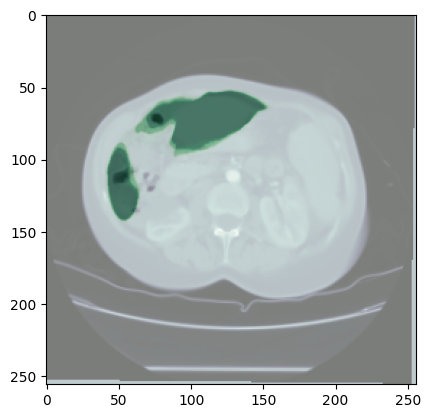

In [ ]:
plt.imshow(registered_volume[13,:,:], cmap='bone')
plt.imshow(registered_mask[13,:,:], cmap='Greens', alpha=0.5)

# 6. Inverse Transformation

In [ ]:
def apply_inverse_rigid_transform(point, inv_q, inv_t):
    # Step 1: Subtract the translation
    x, y, z = point
    x -= inv_t[0]
    y -= inv_t[1]
    z -= inv_t[2]
    
    # Step 2: Rotate using inverse quaternion
    p = (0, x, y, z)
    p_rotated = multiply_quaternions(inv_q, multiply_quaternions(p, conjugate_quaternion(inv_q)))
    
    return (p_rotated[1], p_rotated[2], p_rotated[3])

def inverse_landmarks(landmarks, invq, invt):
    return np.array([
    apply_inverse_rigid_transform(p, invq, invt)
    for p in landmarks
])

In [ ]:
inv2 = conjugate_quaternion(transformation2[:4])
t = (0, transformation2[0], transformation2[1], transformation2[2]) 
inv_landmarks = inverse_landmarks(tr)

In [ ]:
inv1 = conjugate_quaternion(transformation1[:4])
t = (0, -transformation1[0], -transformation1[1], -transformation1[2]) 
t_rotated = multiply_quaternions(inv1, multiply_quaternions(t,transformation1[:4]))
inverse_translation = (t_rotated[1], t_rotated[2], t_rotated[3])

In [ ]:
print(mean_squared_differences(ct_volumeInput, registered_volume))
print(mean_absolute_error(ct_volumeInput, registered_volume))
print(mutual_information(ct_volumeInput, registered_volume))

44329.686482985875
74.91661074251073
0.4721002801573495
